In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, auc
from sklearn.metrics import roc_auc_score,precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
df  = pd.read_csv('dataset/pre_process_all_news_days.csv', encoding = "ISO-8859-1", parse_dates=["Date"])

In [3]:
#Get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))    
    cols.append(col)

In [4]:
for col in tqdm(cols):
    # Structure the data
    df[col] = df[col].apply(lambda x: literal_eval(x))  

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


In [5]:
def Evaluation (Method,Comment,Actual, Predicted,Scores):
    ROC_AUC=roc_auc_score(Actual,Predicted)    
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)    
    Scores[Comment] = {'Method':Method,'ROC_AUC':ROC_AUC,'Accuracy':Accuracy,
                       'Precision':Precision,'Recall':Recall,'F1':F1}    

In [6]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [7]:
def headlines_analyze(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for cl in cols:    
        df_h['news'] = df[cl]
        train = df_h[df_h['Date']<'20141231']
        test = df_h[df_h['Date']>'20141231']
        y_train = train[lbl]
        y_test = test[lbl]
        nb_pipeline.fit(train['news'],y_train)
        predictions = nb_pipeline.predict(test['news'])    
        Evaluation ('MultinomialNB()',cl+'_'+lbl,y_test, predictions,sc)

In [8]:
sc={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze(lbl,sc)

In [9]:
df_sc = pd.DataFrame.from_dict(sc, orient='index')

In [10]:
df_sc.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top12_Label_1day,MultinomialNB(),0.556704,0.560847,0.611111,0.295699,0.398551
Top12_Label,MultinomialNB(),0.554099,0.558201,0.543554,0.812500,0.651357
Top25_Label,MultinomialNB(),0.544103,0.547619,0.538462,0.765625,0.632258
Top25_Label_1day,MultinomialNB(),0.536038,0.539683,0.558824,0.306452,0.395833
Top11_Label_1day,MultinomialNB(),0.535114,0.539683,0.575000,0.247312,0.345865
Top10_Label_2day,MultinomialNB(),0.535088,0.568783,0.574074,0.181287,0.275556
Top11_Label,MultinomialNB(),0.532510,0.537037,0.528620,0.817708,0.642127
Top7_Label_5day,MultinomialNB(),0.531158,0.555556,0.604651,0.146893,0.236364
Top13_Label_5day,MultinomialNB(),0.529471,0.555556,0.636364,0.118644,0.200000
Top6_Label,MultinomialNB(),0.529318,0.534392,0.525806,0.848958,0.649402


In [11]:
def headlines_analyze_two(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            cls = col1+'+'+col2             
            df_h['news'] = df[col1]+ df[col2]
            train = df_h[df_h['Date']<'20141231']
            test = df_h[df_h['Date']>'20141231']
            y_train = train[lbl]
            y_test = test[lbl]
            nb_pipeline.fit(train['news'],y_train)
            predictions = nb_pipeline.predict(test['news'])                
            Evaluation ('MultinomialNB()',cls+'_'+lbl,y_test, predictions,sc)

In [12]:
sc_2c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_two(lbl,sc_2c)

100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


In [13]:
df_sc2 = pd.DataFrame.from_dict(sc_2c, orient='index')
df_sc2.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc2.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top10+Top25_Label,MultinomialNB(),0.549899,0.555556,0.537037,0.906250,0.674419
Top10+Top25_Label_1day,MultinomialNB(),0.547211,0.552910,0.660377,0.188172,0.292887
Top10+Top16_Label,MultinomialNB(),0.542339,0.547619,0.533333,0.875000,0.662722
Top16+Top18_Label_1day,MultinomialNB(),0.541919,0.547619,0.641509,0.182796,0.284519
Top10+Top16_Label_1day,MultinomialNB(),0.539651,0.544974,0.612903,0.204301,0.306452
Top18+Top19_Label,MultinomialNB(),0.539315,0.544974,0.530864,0.895833,0.666667
Top11+Top20_Label_1day,MultinomialNB(),0.539231,0.544974,0.634615,0.177419,0.277311
Top11+Top20_Label,MultinomialNB(),0.539231,0.544974,0.530675,0.901042,0.667954
Top16+Top18_Label,MultinomialNB(),0.539231,0.544974,0.530675,0.901042,0.667954
Top6+Top9_Label_2day,MultinomialNB(),0.539156,0.579365,0.714286,0.116959,0.201005


In [14]:
def headlines_analyze_three(lbl,sc):
    df_h = df[['Date',lbl]].copy()
    for i in tqdm(range(1,26)):
        col1 = ("Top{}".format(i))
        for j in range(i+1,26):        
            col2 = ("Top{}".format(j))
            for k in range(j+1,26):
                col3 = ("Top{}".format(k))
                cls = col1+'+'+col2+'+'+col3
                df_h['news'] = df[col1]+ df[col2]+ df[col3]
                train = df_h[df_h['Date']<'20141231']
                test = df_h[df_h['Date']>'20141231']
                y_train = train[lbl]
                y_test = test[lbl]
                nb_pipeline.fit(train['news'],y_train)
                predictions = nb_pipeline.predict(test['news'])                
                Evaluation ('MultinomialNB()',cls+'_'+lbl,y_test, predictions,sc)

In [15]:
sc_3c={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    headlines_analyze_three(lbl,sc_3c)

100%|██████████| 25/25 [03:36<00:00,  8.68s/it]


In [16]:
df_sc3 = pd.DataFrame.from_dict(sc_3c, orient='index')
df_sc3.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc3.head(10)

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
Top2+Top7+Top10_Label_1day,MultinomialNB(),0.549311,0.555556,0.725000,0.155914,0.256637
Top2+Top13+Top19_Label,MultinomialNB(),0.546791,0.552910,0.534328,0.932292,0.679317
Top2+Top7+Top10_Label,MultinomialNB(),0.546707,0.552910,0.534125,0.937500,0.680529
Top10+Top12+Top18_Label,MultinomialNB(),0.545951,0.552910,0.532394,0.984375,0.691042
Top18+Top19+Top21_Label,MultinomialNB(),0.544187,0.550265,0.532934,0.927083,0.676806
Top2+Top13+Top19_Label_1day,MultinomialNB(),0.544103,0.550265,0.690476,0.155914,0.254386
Top7+Top10+Top25_Label,MultinomialNB(),0.544019,0.550265,0.532544,0.937500,0.679245
Top4+Top10+Top19_Label_1day,MultinomialNB(),0.543935,0.550265,0.710526,0.145161,0.241071
Top10+Top12+Top18_Label_1day,MultinomialNB(),0.543263,0.550265,0.863636,0.102151,0.182692
Top18+Top19+Top21_Label_1day,MultinomialNB(),0.541415,0.547619,0.682927,0.150538,0.246696


In [17]:
def analyze_all_news(lbl):
    df_h = df[['Date',lbl]].copy()
    df_h['news'] = df['news_stemmed']
    train = df_h[df_h['Date']<'20141231']
    test = df_h[df_h['Date']>'20141231']
    y_train = train[lbl]
    y_test = test[lbl]
    nb_pipeline.fit(train['news'],y_train)
    predictions = nb_pipeline.predict(test['news'])                
    Evaluation ('XGBClassifier()','news_stemmed'+lbl,y_test, predictions,sc_news)

In [18]:
sc_news={}
for i, lbl in enumerate(['Label','Label_1day','Label_2day', 'Label_3day', 'Label_4day', 'Label_5day']):
    analyze_all_news(lbl)

In [19]:
df_sc_news = pd.DataFrame.from_dict(sc_news, orient='index')
df_sc_news.sort_values(by=['ROC_AUC','Accuracy'],ascending=False,inplace=True)
df_sc_news

,Method,ROC_AUC,Accuracy,Precision,Recall,F1
news_stemmedLabel_2day,XGBClassifier(),0.5,0.547619,0.000000,0.0,0.000000
news_stemmedLabel_4day,XGBClassifier(),0.5,0.534392,0.000000,0.0,0.000000
news_stemmedLabel_3day,XGBClassifier(),0.5,0.531746,0.000000,0.0,0.000000
news_stemmedLabel_5day,XGBClassifier(),0.5,0.531746,0.000000,0.0,0.000000
news_stemmedLabel,XGBClassifier(),0.5,0.507937,0.507937,1.0,0.673684
news_stemmedLabel_1day,XGBClassifier(),0.5,0.507937,0.000000,0.0,0.000000


# Parameters Tuning

## One Headline

In [102]:
from sklearn.naive_bayes import BernoulliNB
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [112]:
params = {'bow__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'bow__max_features': (10000,15000, 20000),
          'bow__min_df': (5,10),
          'tfidf__use_idf': (True, False),          
          'classifier__alpha': (1,0.5,1e-2, 1e-3)}

In [113]:
df_h = df[['Date','Label_1day','Top25']].copy()   
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label_1day']
y_test = test['Label_1day']

In [114]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['Top25'], y_train)

In [115]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__max_features': 10000, 'bow__min_df': 10, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.5, 'tfidf__use_idf': True}
accuracy: 0.5559022505339308


In [121]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(min_df=10, max_features=10000, ngram_range=(1, 1), analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer(use_idf=True)),  
    ('classifier', BernoulliNB(alpha=0.5 )) ])

In [122]:
nb_pipe.fit(train['Top25'],y_train)
prediction = nb_pipe.predict(test['Top25'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       192
           1       0.54      0.45      0.49       186

    accuracy                           0.54       378
   macro avg       0.54      0.54      0.54       378
weighted avg       0.54      0.54      0.54       378

Accuracy: 0.5396825396825397


Text(0.5, 15.0, 'Predicted')

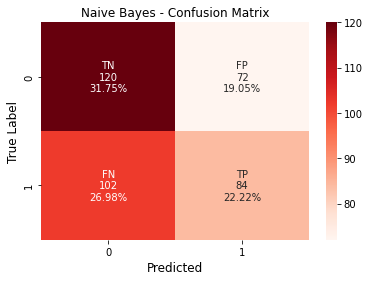

In [118]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Two Headlines

In [166]:
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [167]:
params = {'bow__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'bow__max_features': (1,4,5,8),
          'bow__min_df': (1,2,4,5)
         }

In [168]:
df_h = df[['Date','Label','Top10','Top25']].copy()   
df_h['news'] = df_h['Top10']+df_h['Top25']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label']
y_test = test['Label']

In [169]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [170]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__max_features': 1, 'bow__min_df': 1, 'bow__ngram_range': (1, 1)}
accuracy: 0.5422360900213572


In [179]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB( )) ])

In [180]:
nb_pipe.fit(train['news'],y_train)
prediction = nb_pipe.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.70      0.20      0.31       186
           1       0.54      0.92      0.68       192

    accuracy                           0.56       378
   macro avg       0.62      0.56      0.50       378
weighted avg       0.62      0.56      0.50       378

Accuracy: 0.5634920634920635


Text(0.5, 15.0, 'Predicted')

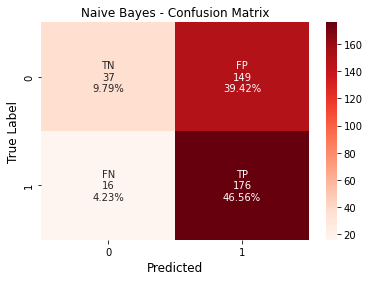

In [181]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)

## Three Headlines 

In [182]:
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [183]:
params = {'bow__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'bow__max_features': (1,4,5,8),
          'bow__min_df': (1,2,4,5)
         }

In [184]:
df_h = df[['Date','Label','Top10','Top16','Top25']].copy()   
df_h['news'] = df_h['Top10']+df_h['Top16']+df_h['Top25']
train = df_h[df_h['Date']<'20141231']
test = df_h[df_h['Date']>'20141231']
y_train = train['Label']
y_test = test['Label']

In [185]:
gs = GridSearchCV(estimator=nb_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(train['news'], y_train)

In [186]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'bow__max_features': 1, 'bow__min_df': 1, 'bow__ngram_range': (1, 1)}
accuracy: 0.5422360900213572


In [194]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer(min_df=1, ngram_range=(1, 1),analyzer=lambda x: x )),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB( )) ])

In [195]:
nb_pipe.fit(train['news'],y_train)
prediction = nb_pipe.predict(test['news'])

print(classification_report(y_test, prediction))
matrix=confusion_matrix(y_test,prediction)
score=accuracy_score(y_test,prediction)
print("Accuracy:",score)

              precision    recall  f1-score   support

           0       0.76      0.14      0.24       186
           1       0.53      0.96      0.69       192

    accuracy                           0.56       378
   macro avg       0.65      0.55      0.46       378
weighted avg       0.65      0.56      0.47       378

Accuracy: 0.5555555555555556


Text(0.5, 15.0, 'Predicted')

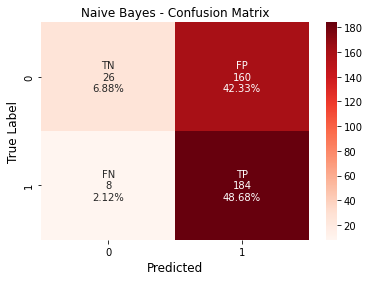

In [196]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
            matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                 matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
      zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
plt.title('Naive Bayes - Confusion Matrix')

sns.heatmap(matrix, annot=labels, fmt="", cmap='Reds')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted',fontsize=12)